<a href="https://colab.research.google.com/github/Zulfa-Varvani/ML-things/blob/main/water_quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import files
uploaded = files.upload()

Saving water.csv to water.csv


In [2]:
import io
df = pd.read_csv(io.BytesIO(uploaded['water.csv']))
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [3]:
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


In [4]:
df.isna().sum()
#15% of pH values missing
#24% of sulfate values missing
#5% of trihalomethanes missing

#why are they missing though? what values need to be imputed?
#pH is very important, need to ensure values are between 6.5 - 8.5

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [5]:
df['ph'].between(6.5,8.5).any()
#all values are between 6.5 and 8.5 <-- follow guidelines and is safe for imputing missing values
#trihalomethanes are also safe for imputing

True

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier

"""
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestClassifier(n_estimators=10, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)
"""

x = df.drop('Potability', axis=1)
y = df.Potability

#x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=0)

In [13]:
#see if we can drop columns with missing values
#both train and test set have same columns that are missing, it is safe to drop those columns
"""
cols_missing = ['ph', 'Sulfate', 'Trihalomethanes']

train_miss = x_train.drop(cols_missing, axis=1)
test_miss = x_test.drop(cols_missing,axis=1)

print(f'MAE from dropping: {score_dataset(train_miss, test_miss, y_train, y_test)*1000}')
"""

MAE from dropping: 387.1951219512195


In [15]:
#now we will impute any missing values with SimpleImputer
"""
from sklearn.impute import SimpleImputer

imp = SimpleImputer()
imp_train = pd.DataFrame(imp.fit_transform(x_train))
imp_test = pd.DataFrame(imp.transform(x_test))

imp_train.columns = x_train.columns
imp_test.columns = x_test.columns

print(f'MAE from imputing: {score_dataset(imp_train, imp_test, y_train, y_test)*1000}')
"""
#imputing these missing values give a better score for MAE, therefore we will impute the missing values
#from previous assessment, imputing is also safe to do

MAE from imputing: 356.7073170731707


In [42]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer()
x_imp = pd.DataFrame(imp.fit_transform(x))
x_imp.columns = x.columns

x_imp.isna().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
dtype: int64

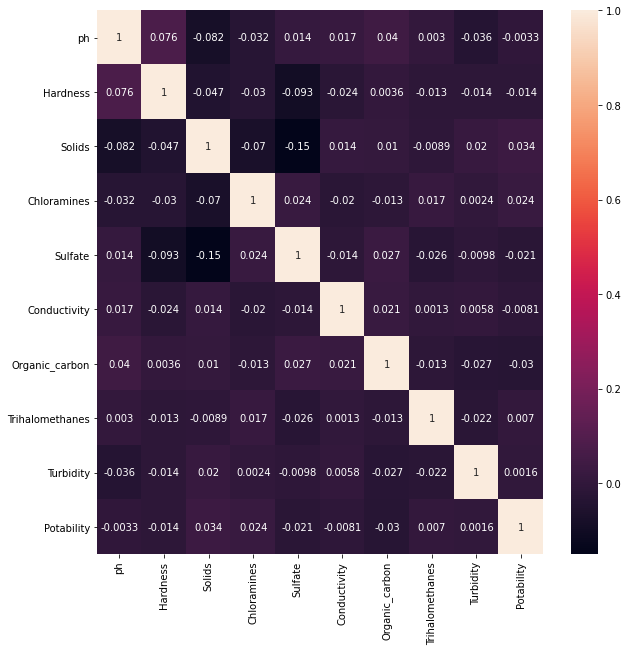

In [49]:
data = pd.concat([x_imp,y], axis=1)
#data.head()
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(),annot=True)

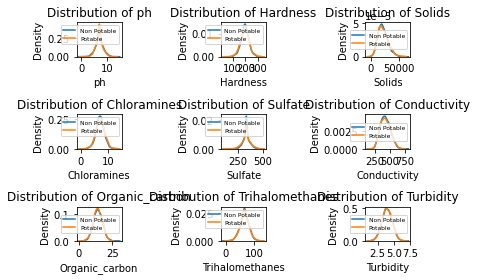

In [68]:
non = data.query('Potability == 0')
pot = data.query('Potability == 1')

for ax,col in enumerate(data.columns[:9]):
  plt.subplot(3,3,ax+1)
  plt.title(f'Distribution of {col}')
  sns.kdeplot(x=non[col], label='Non Potable')
  sns.kdeplot(x=pot[col], label='Potable')
  plt.legend(prop=dict(size=6))

plt.tight_layout()